In [555]:
import pandas as pd
import numpy as np
from datetime import date
import quantstats as qs

Tratando as bases

In [556]:
dict_moedas = ['ZAR', 'AFS', 'AUD', 'AUS', 'ARB', 'ARS', 'CAD', 'CAN', 'CLP', 
'CHL', 'CNY', 'CNH', 'DOL', 'EUR', 'EUP', 'GBP', 'GBR', 'JPY', 'JAP', 'MXN', 'MEX',
'NOK', 'NZD', 'NZL', 'RUB', 'SEK', 'CHF', 'SWI', 'TRY', 'TUQ']

In [557]:
df=pd.read_csv('https://raw.githubusercontent.com/iqfc/B3_Scrapper/main/ft_moedas_1.0.csv',delimiter=',',low_memory=False)
df=df.assign(Contract_cod=df.Contract+'_'+df['Contract Months'])

df['Settlement Price']=df['Settlement Price'].str.replace(',','')
df['Settlement Price']=pd.to_numeric(df['Settlement Price'])

df['Financial Volume (R$)']=df['Financial Volume (R$)'].str.replace(',','')
df['Financial Volume (R$)']=pd.to_numeric(df['Financial Volume (R$)'])

dic_map_1={'JAN':1,'FEV':2,'MAR':3,'ABR':4,'MAI':5,'JUN':6,'JUL':7,'AGO':8,'SET':9,'OUT':10,'NOV':11,'DEZ':12}
dic_map_2={'F':1,'G':2,'H':3,'J':4,'K':5,'M':6,'N':7,'Q':8,'U':9,'V':10,'X':11,'Z':12}

def map_contrat_venc(x):

    if len(x.strip())==3:
        
        year=2000+int(x[1:])
        month=int(dic_map_2.get(x[0]))
        day=1

        return pd.Timestamp(year,month,day)
    else:

        year=2000+int(x[3:])
        month=dic_map_1.get(x[:3])
        day=1

        return pd.Timestamp(year,month,day)

df['Contract Months']=df['Contract Months'].apply(map_contrat_venc)

In [558]:
df.Date=pd.to_datetime(df.Date)

Settlement price dos futuros

In [559]:
ft_price=df.loc[:,['Contract Months','Contract','Settlement Price','Date','Financial Volume (R$)','Contract_cod']]
ft_price.rename(columns={'Financial Volume (R$)': 'Financial_Volume_RS'}, inplace=True)
ft_price['Settlement Price']=pd.to_numeric(ft_price['Settlement Price'])


Importando Spot Prices

In [560]:
# spot=pd.read_csv('CSV_moedas_1.csv',delimiter=',').set_index('Unnamed: 0')
spot=pd.read_csv(r'https://raw.githubusercontent.com/iqfc/B3_Scrapper/main/CSV%20moedas%201%20BRL.csv',delimiter=',')

fix_names=(['Date','TUQ','SWI','SEK','RUB','NZL','NOK','MEX','JAP','GBR','EUP','CNH','CHL','CAN','ARS','AUS','AFS','USD','BRL'])
spot.columns=fix_names
spot.rename(columns={'BRL': 'DOL'}, inplace=True)

spot.Date=pd.to_datetime(spot.Date)
spot=spot.set_index('Date')


#Devemos fazer o inverso para comparar com o futuro
spot.GBR=1/spot.GBR
spot.EUP=1/spot.EUP
spot.AUS=1/spot.AUS

Geting only the contracts available in all bases

In [561]:
contracts_available=pd.DataFrame(spot.columns).merge(pd.DataFrame(df.Contract.unique()),how='inner')
contracts_available=list(contracts_available[0])

#Revisando os dados notamos erros nesse contratos e por isso decidimos por hora retira-lo do backteste
contracts_available.remove('ARS')


spot=spot.loc[:,contracts_available]
spot=spot.reset_index()
ft_price=ft_price[ft_price.Contract.isin(contracts_available)]



In [562]:
contracts_available

['MEX', 'JAP', 'GBR', 'EUP', 'CNH', 'CHL', 'CAN', 'AUS', 'AFS', 'DOL']

In [563]:

def get_spot(x):

    spot_price_contract=day_spot[str(x)]*1000
    
    return spot_price_contract

def get_day(x):

    return x.days


Backtest Structure Here

In [567]:
#Detalhe importante, para comparar datas usando o pandas agora precisamos colocar tudo no formado do proprio pandas, diferente do
#que faziamos antes no datetime.date, ou apenas o date, assim o startdate e end_date devem estar no formato Timestap


start_date=pd.Timestamp(2010,1,1)
end_date=pd.Timestamp(2022,12,31)
rebal=1
Retornos=pd.DataFrame()
n=5
#não precisa de lookback pois visamos pegar a data mais atual



while True:

    rebalanceamento=start_date+pd.DateOffset(months=rebal)

    if start_date<end_date:

        data_analise=start_date-pd.DateOffset(days=1)
        day_ft_price=ft_price[(ft_price.Date > data_analise) & (ft_price.Date < start_date)]

        

        # Check holidays and weekends
        while True:
            if day_ft_price.empty:

                data_analise=data_analise-pd.DateOffset(days=1)
                day_ft_price=ft_price[(ft_price.Date == data_analise) & (ft_price.Financial_Volume_RS>0)].copy()
            
            else:break




        day_spot=spot[(spot.Date == data_analise)]


        #Organizando os preços spots no mesmo codigo
        day_ft_price['spot']=day_ft_price['Contract'].apply(get_spot)

        #Criando uma coluna com o cálculo do carry
        day_ft_price['carry']=day_ft_price['Settlement Price']/day_ft_price.spot

        #Medindo o tempo até vencimento e retirando vencimento dentro do rebal
        day_ft_price=day_ft_price.assign(delta_days=day_ft_price['Contract Months']-day_ft_price.Date)
        day_ft_price.delta_days=day_ft_price.delta_days.apply(get_day)
        day_ft_price=day_ft_price[day_ft_price.delta_days>rebal*30]

        #Padronizano o carry para comparar entre todas as datas e comprar os maiores carrys
        day_ft_price.carry=day_ft_price.carry**(1/day_ft_price.delta_days)


        #Selecionando os ativos
        day_ft_price=day_ft_price.sort_values(by='carry',ascending=False)
        book_currency=list(day_ft_price.Contract_cod.iloc[:n])

        #pesando os ativos
        #essa pesagem deu alguns erros
        # length=len(day_ft_price)
        # day_ft_price['weights']=np.arange(length,0,-1)-((length+1)/2)
        # day_ft_price['weights']=day_ft_price.weights/((length+1)*length/4)
        # weights=day_ft_price.loc[:,['Contract_cod','weights']].set_index('Contract_cod')

        #

        #backtest
        backtest=ft_price[(ft_price.Date >= start_date) & (ft_price.Date < rebalanceamento) & (ft_price.Contract_cod.isin(book_currency))]
        backtest=backtest.pivot_table(columns='Contract_cod',values='Settlement Price',index='Date')
        backtest=backtest.pct_change()*-1
        # backtest=backtest.pct_change().replace(np.nan,0).add(1)
        # backtest.iloc[0]=backtest.iloc[0]*weights.weights
        # backtest=backtest.cumprod()
        # backtest['Strategy_return']=backtest.sum(axis=1)
        backtest['Strategy_return']=backtest.mean(axis=1)


        Retornos = pd.concat([Retornos,backtest['Strategy_return']])
        start_date=start_date+pd.DateOffset(months=rebal)
    
    else:break

Retornos=Retornos.add(1).dropna().cumprod()


                           Strategy
-------------------------  ----------
Start Period               2010-01-05
End Period                 2022-12-29
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -14.73%
CAGR﹪                     -1.22%

Sharpe                     -0.04
Prob. Sharpe Ratio         44.98%
Smart Sharpe               -0.04
Sortino                    -0.05
Smart Sortino              -0.05
Sortino/√2                 -0.04
Smart Sortino/√2           -0.03
Omega                      0.99

Max Drawdown               -42.81%
Longest DD Days            4173
Volatility (ann.)          12.96%
Calmar                     -0.03
Skew                       -0.28
Kurtosis                   4.33

Expected Daily %           -0.01%
Expected Monthly %         -0.1%
Expected Yearly %          -1.22%
Kelly Criterion            -0.32%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.35%
Expected Shortfall (cVaR)  -1.35%

Max Consecuti

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-07-27,2015-09-23,2022-12-29,4173,-42.809934,-40.415713
2,2010-01-11,2010-05-06,2010-09-02,234,-9.127752,-8.777004
3,2011-04-27,2011-05-16,2011-06-03,37,-4.209718,-4.204166
4,2010-10-14,2010-11-16,2010-12-29,76,-3.966649,-3.544702
5,2011-03-09,2011-03-17,2011-03-30,21,-2.743980,-1.829354


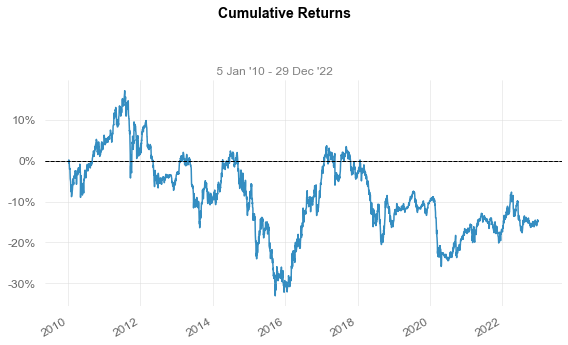

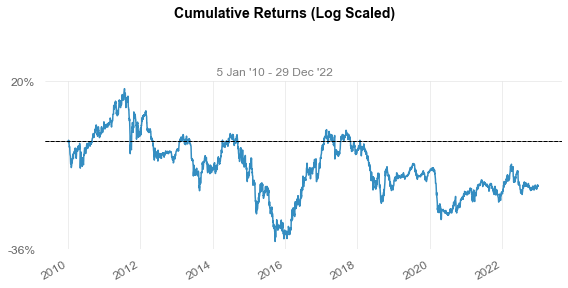

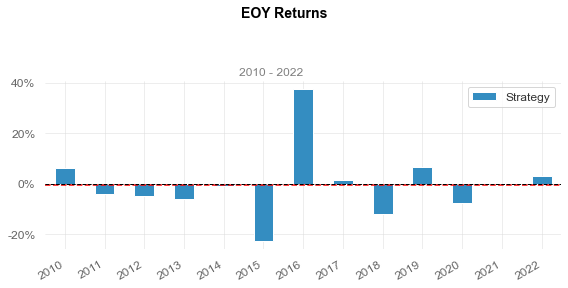

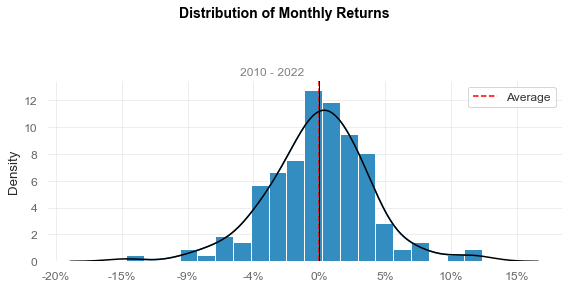

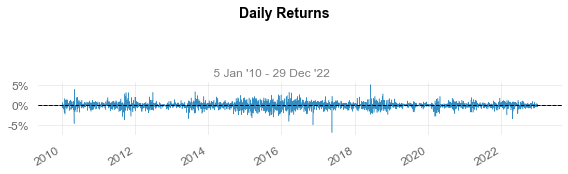

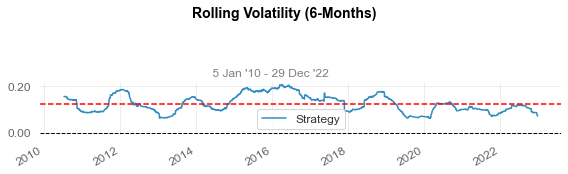

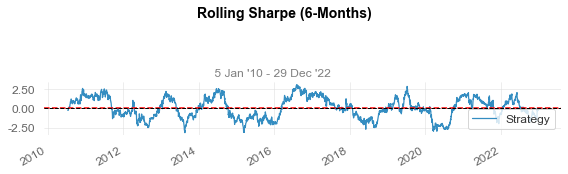

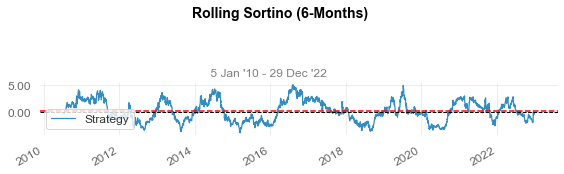

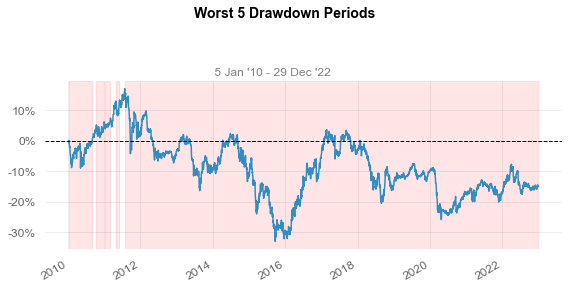

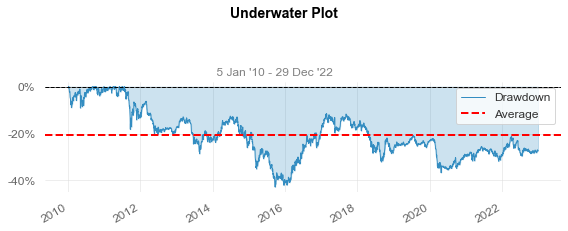

c:\Users\Gustavo Aurelio\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:967: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


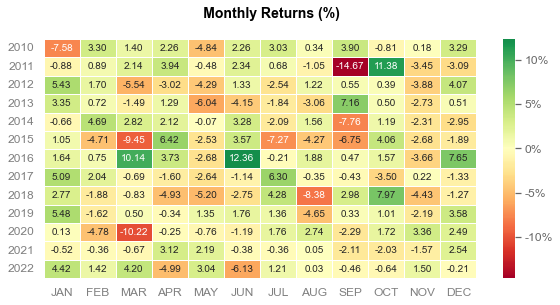

c:\Users\Gustavo Aurelio\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


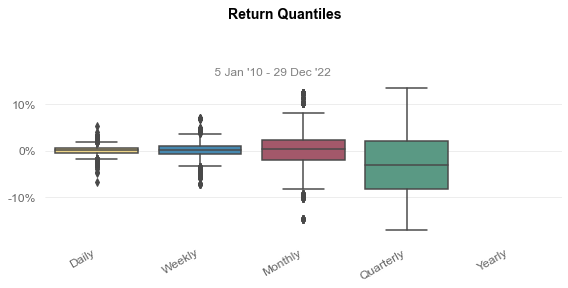

In [568]:
qs.reports.full(Retornos[0])